In [2]:
import re
import random
import math
from collections import Counter
from tqdm import tqdm

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/naman/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


device(type='cuda')

In [3]:
class BPETokenizer:
    def __init__(self, vocab_size=20000):
        self.vocab_size = vocab_size
        self.merges = []
        self.token_to_id = {}
        self.id_to_token = {}

    def _preprocess(self, text):
        text = text.lower()
        text = re.sub(r"[^a-z0-9\s]", "", text)
        return text.split()

    def train(self, texts):
        vocab = Counter()
        for text in texts:
            for word in self._preprocess(text):
                vocab[tuple(list(word) + ["</w>"])] += 1

        def get_pair_stats(vocab):
            stats = Counter()
            for word, freq in vocab.items():
                for i in range(len(word) - 1):
                    stats[(word[i], word[i+1])] += freq
            return stats

        while True:
            stats = get_pair_stats(vocab)
            if not stats:
                break

            best = stats.most_common(1)[0][0]
            self.merges.append(best)

            new_vocab = {}
            for word, freq in vocab.items():
                new_word = []
                i = 0
                while i < len(word):
                    if i < len(word) - 1 and (word[i], word[i+1]) == best:
                        new_word.append(word[i] + word[i+1])
                        i += 2
                    else:
                        new_word.append(word[i])
                        i += 1
                new_vocab[tuple(new_word)] = freq

            vocab = new_vocab
            if len({sym for word in vocab for sym in word}) >= self.vocab_size:
                break

        tokens = sorted({sym for word in vocab for sym in word})
        self.token_to_id = {t: i for i, t in enumerate(tokens)}
        self.id_to_token = {i: t for t, i in self.token_to_id.items()}

    def encode(self, text):
        tokens = []
        for word in self._preprocess(text):
            symbols = list(word) + ["</w>"]
            for merge in self.merges:
                i = 0
                while i < len(symbols) - 1:
                    if (symbols[i], symbols[i+1]) == merge:
                        symbols[i:i+2] = ["".join(merge)]
                    else:
                        i += 1
            tokens.extend([self.token_to_id[s] for s in symbols if s in self.token_to_id])
        return tokens

    def decode(self, ids):
        return "".join(self.id_to_token[i] for i in ids).replace("</w>", " ")

In [4]:
wiki_path = "/home/naman/Task-0/archive/AllCombined.txt"

with open(wiki_path, encoding="utf-8") as f:
    wiki_sentences = [line.strip() for line in f if line.strip()]

wiki_sentences = wiki_sentences[:50000]
len(wiki_sentences)

50000

In [5]:
tokenizer = BPETokenizer(vocab_size=20000)
tokenizer.train(wiki_sentences)

vocab_size = len(tokenizer.token_to_id)
print("Final vocab size:", vocab_size)

Final vocab size: 20000


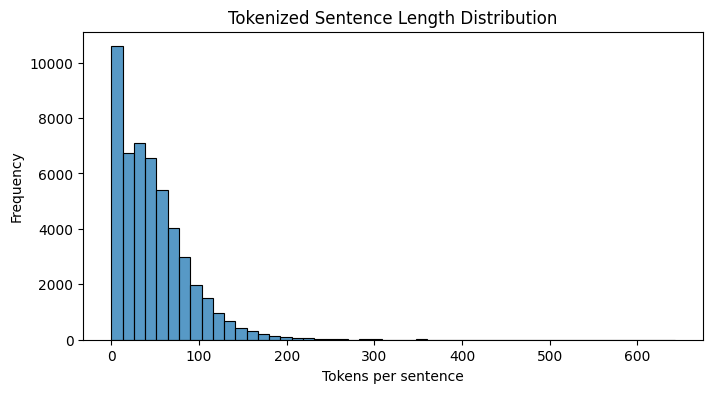

Mean length: 47.48924
95th percentile: 123.0


In [6]:
lengths = [len(tokenizer.encode(s)) for s in wiki_sentences]

plt.figure(figsize=(8,4))
sns.histplot(lengths, bins=50)
plt.title("Tokenized Sentence Length Distribution")
plt.xlabel("Tokens per sentence")
plt.ylabel("Frequency")
plt.show()

print("Mean length:", np.mean(lengths))
print("95th percentile:", np.percentile(lengths, 95))

In [7]:
token_counts = Counter()

for s in wiki_sentences:
    token_counts.update(tokenizer.encode(s))

unigram = np.zeros(vocab_size, dtype=np.float64)
for tid, c in token_counts.items():
    unigram[tid] = c

unigram = unigram ** 0.75
unigram /= unigram.sum()

unigram_dist = torch.tensor(unigram, device=DEVICE)

In [8]:
class CBOWDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer, window):
        self.data = []
        for text in texts:
            tokens = tokenizer.encode(text)
            for i in range(window, len(tokens)-window):
                ctx = tokens[i-window:i] + tokens[i+1:i+window+1]
                self.data.append((ctx, tokens[i]))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        c, t = self.data[idx]
        return torch.tensor(c), torch.tensor(t)

In [9]:
class CBOWNegSampling(nn.Module):
    def __init__(self, vocab_size, dim):
        super().__init__()
        self.in_embed = nn.Embedding(vocab_size, dim)
        self.out_embed = nn.Embedding(vocab_size, dim)

        nn.init.uniform_(self.in_embed.weight, -0.5/dim, 0.5/dim)
        nn.init.zeros_(self.out_embed.weight)

    def forward(self, ctx, target, neg):
        v = self.in_embed(ctx).mean(dim=1)
        pos = torch.sum(v * self.out_embed(target), dim=1)
        neg_score = torch.bmm(self.out_embed(neg), v.unsqueeze(2)).squeeze(2)

        loss = -(
            torch.log(torch.sigmoid(pos) + 1e-9) +
            torch.sum(torch.log(torch.sigmoid(-neg_score) + 1e-9), dim=1)
        )
        return loss.mean()

In [ ]:
EMBED_DIM = 384
WINDOW = 5
NEG_K = 5
BATCH = 512
EPOCHS = 3

dataset = CBOWDataset(wiki_sentences, tokenizer, WINDOW)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH, shuffle=True)

model = CBOWNegSampling(vocab_size, EMBED_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.001)

losses = []

for e in range(EPOCHS):
    total = 0
    for ctx, tgt in tqdm(loader):
        ctx, tgt = ctx.to(DEVICE), tgt.to(DEVICE)
        neg = torch.multinomial(unigram_dist, tgt.size(0)*NEG_K, True).view(tgt.size(0), NEG_K)

        optimizer.zero_grad()
        loss = model(ctx, tgt, neg)
        loss.backward()
        optimizer.step()
        total += loss.item()

    avg = total / len(loader)
    losses.append(avg)
    print(f"Epoch {e+1} | Loss {avg:.4f}")

100%|██████████| 3781/3781 [00:32<00:00, 115.28it/s]


Epoch 1 | Loss 2.4209


100%|██████████| 3781/3781 [00:32<00:00, 116.96it/s]


Epoch 2 | Loss 2.0015


100%|██████████| 3781/3781 [00:32<00:00, 114.69it/s]

Epoch 3 | Loss 1.8107


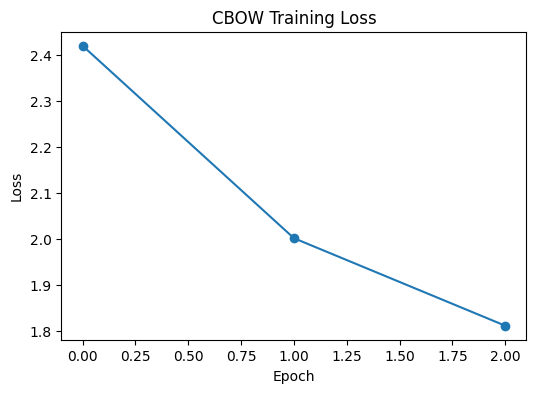

In [12]:
plt.figure(figsize=(6,4))
plt.plot(losses, marker="o")
plt.title("CBOW Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [13]:
embeddings = model.in_embed.weight.detach().cpu().numpy()

In [18]:
pip install datasets

Note: you may need to restart the kernel to use updated packages.


In [28]:
texts = []
labels = []

label_map = {
    "negative": 0,
    "neutral": 1,
    "positive": 2
}

bad_lines = 0

with open(
    "/home/naman/Task-0/Sentences_AllAgree.txt",
    encoding="latin-1"
) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        # Each line: <sentence>@<label>
        if "@" not in line:
            bad_lines += 1
            continue

        sentence, label = line.rsplit("@", 1)
        label = label.strip().lower()

        if label not in label_map:
            bad_lines += 1
            continue

        texts.append(sentence.strip())
        labels.append(label_map[label])

texts = np.array(texts)
labels = np.array(labels, dtype=np.int64)

print("Samples loaded:", len(texts))
print("Label distribution:", np.bincount(labels))

'''0 = negative → 303

1 = neutral → 1391

2 = positive → 570'''

print("Skipped malformed lines:", bad_lines)

Samples loaded: 2264
Label distribution: [ 303 1391  570]
Skipped malformed lines: 0


In [29]:
def doc_vector(text):
    ids = tokenizer.encode(text)
    if not ids:
        return np.zeros(EMBED_DIM)
    return embeddings[ids].mean(axis=0)

X = np.vstack([doc_vector(t) for t in texts])
y = labels


In [30]:
clf = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",
    n_jobs=-1
)
clf.fit(X, y)

preds = clf.predict(X)
print("CBOW + LR Macro F1:", f1_score(y, preds, average="macro"))


CBOW + LR Macro F1: 0.6704860461096961


In [31]:
sid = SentimentIntensityAnalyzer()

def vader_pred(t):
    c = sid.polarity_scores(t)["compound"]
    if c > 0.05: return 2
    if c < -0.05: return 0
    return 1

v_preds = np.array([vader_pred(t) for t in texts])
print("VADER Macro F1:", f1_score(y, v_preds, average="macro"))


VADER Macro F1: 0.4866877018508586


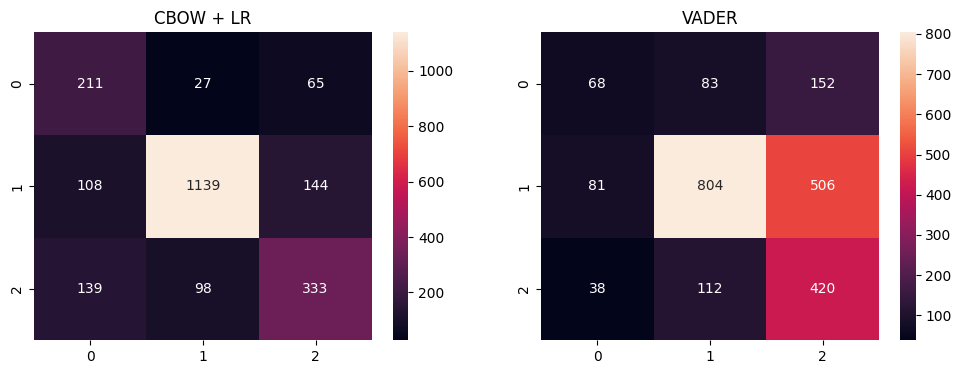

In [32]:
fig, ax = plt.subplots(1,2, figsize=(12,4))

sns.heatmap(confusion_matrix(y, preds), annot=True, fmt="d", ax=ax[0])
ax[0].set_title("CBOW + LR")

sns.heatmap(confusion_matrix(y, v_preds), annot=True, fmt="d", ax=ax[1])
ax[1].set_title("VADER")

plt.show()
